# How Many Soldiers Do You Need To Beat The Night King?

The [538 Riddler](https://fivethirtyeight.com/features/how-many-soldiers-do-you-need-to-beat-the-night-king/) asks us to consider a battle between The Night King's army of the dead and the army of the living:

> *One soldier steps forward from each army and the pair duels—half the time the living soldier wins, half the time the dead soldier wins. If the living soldier wins, the dead soldier is dead forever. If the dead soldier wins, both he and the (formerly) living soldier return to the army of the dead.  The battle continues until one army is entirely eliminated. What starting sizes of the armies, living and dead, give each army a 50-50 chance of winning?*

# Module Imports


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import collections
import functools

cache = functools.lru_cache(None)
sys.setrecursionlimit(50000)

# How Many Soldiers? Analysis

My analysis: let $P_{d,a}$ be the probability that the living army wins. The result of a duel is either to decrease the dead by one, or to transfer one of the living to the dead. The two outcomes are equally likely, so:

$$P_{d, a} = \frac{P_{d-1, a} + P_{d+1, a-1}}{2}$$

I'll answer the question "what is the minimum number of living soldiers necessary to have at least a 50% chance versus `d` dead soldiers?" with `living_needed(d)` and  I'll define `P_live_win(dead, alive)` to compute $P_{d,a}$.


In [2]:
def living_needed(dead, p=0.50):
    """How many living soldiers are needed for a `p` probability of defeating `dead` soldiers?"""
    return next(a for a in range(1, sys.maxsize) if P_live_win(dead, a) >= p)

@cache#@Cache2d(12000, 12000)
def P_live_win(dead, alive):
    """The probability that the living win, given the number of dead and alive soldiers."""
    return (1 if not dead  else
            0 if not alive else
            (P_live_win(dead - 1, alive) + P_live_win(dead + 1, alive - 1)) / 2)

In [3]:
[living_needed(d) for d in range(1, 11)]

[1, 4, 9, 17, 26, 38, 51, 67, 85, 106]

That's interesting: `[1, 4, 9, 17, 26]` would be the sequence of perfect squares if we subtract 1 from `17` and `26`. So one answer would be: 

> *For d dead soldiers, we need a little more than d<sup>2</sup> living soldiers.*

Let's examine a bit more closely: for each number of dead soldiers, show the number of living soldiers needed for at least an even chance of victory, along with the actual victory percentage, and the quadratic formula that fits best:

In [4]:
def best_fit_quadratic(X, Y):
    "Best-fit second-degree polynomial for X, Y points."
    a, b, c = np.polyfit(X, Y, 2)
    f = lambda x: a*x**2 + b*x + c
    err = max(abs(f(x) - y) for x, y in zip(X, Y))
    f.__doc__ = f'{a:.3f}d^2 {b:+.3f}d {c:+.3f} (±{err:.1f})'
    return f

def show(D):
    for d in D:
        a = living_needed(d)
        f = best_fit_quadratic(range(1, d + 1), [living_needed(d) for d in range(1, d + 1)])
        print(f'P({d:3}, {a:5}) = {P_live_win(d, a):.2%} | a = {f.__doc__}')

In [5]:
%time show(range(10, 101, 10))

P( 10,   106) = 50.12% | a = 1.076d^2 -0.221d +0.200 (±0.5)
P( 20,   431) = 50.04% | a = 1.100d^2 -0.509d +0.804 (±0.7)
P( 30,   975) = 50.01% | a = 1.099d^2 -0.500d +0.777 (±0.6)
P( 40,  1739) = 50.00% | a = 1.098d^2 -0.472d +0.652 (±0.7)
P( 50,  2724) = 50.01% | a = 1.099d^2 -0.490d +0.753 (±0.6)
P( 60,  3928) = 50.01% | a = 1.099d^2 -0.491d +0.760 (±0.6)
P( 70,  5351) = 50.00% | a = 1.099d^2 -0.489d +0.733 (±0.6)
P( 80,  6995) = 50.00% | a = 1.099d^2 -0.492d +0.772 (±0.6)
P( 90,  8858) = 50.00% | a = 1.099d^2 -0.492d +0.763 (±0.6)
P(100, 10942) = 50.00% | a = 1.099d^2 -0.491d +0.756 (±0.6)
CPU times: user 7min 5s, sys: 50.8 s, total: 7min 56s
Wall time: 7min 56s


Two things are  interesting here: First, the quadratic function is a really good fit. All the way up to `d = 100` and `a = 10942` the quadratic function fits every point to within ±0.6 (i.e., it is never off by as much as a single soldier; it is accurate to one part in 20,000).

Second, the quadratic is converging; the coefficients don't change much from one line to the next. But I have no idea *why* we get `1.099d^2`.

(**Addendum:** [The 538 Riddler](https://fivethirtyeight.com/features/one-small-step-for-man-one-giant-coin-flip-for-mankind/) provided an answer in the form of  [an analysis](http://www.bhsu.edu/Portals/0/Faculty-Staff/Daniel-Swenson/Riddler/night_king.pdf?ver=2019-05-19-173548-210) by Dan Swenson unisng algebraic manipulation. We agree on $1.099d^2 - 0.5d$, but Swenson says the last term should be $0.5$, and I have $0.8$ and trending up; maybe it should be 1?)

Let's see a plot:

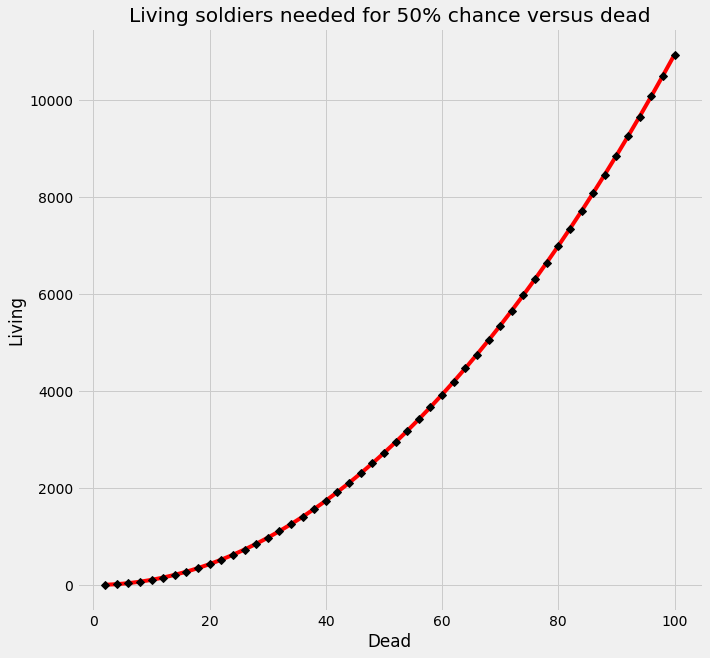

In [6]:
def plot_needed(D):
    "Plot the number of living soldiers needed for a 50% chance to defeat the dead."
    A = [living_needed(d) for d in D]
    plt.xlabel('Dead'); plt.ylabel('Living')
    plt.title('Living soldiers needed for 50% chance versus dead')
    f = best_fit_quadratic(D, A)
    plt.plot(D, [f(d) for d in D], 'r-')
    plt.plot(D, A, 'kD')

plt.rcParams["figure.figsize"] = [10, 10]
plt.style.use('fivethirtyeight')
plt.grid(True); 

plot_needed(range(2, 101, 2))

We see that the quadratic fit remains good, always less than one soldier off.

# Who remains?

So far, we've concentrated on who wins the battle&mdash;which side has any soldiers left at all. But I'd also like to know the full probability distribution over how many soldiers remain. 

I'll use `collections.Counter` to implement probability distributions, and define `remains(dead, alive)` to return a distribution of soldiers, with positive numbers meaning that living soldiers remain and negative meaning that dead soldiers remain. The function `plot_remains` will plot one or more such distribution.

In [7]:
ProbDist = collections.Counter

@cache
def remains(dead, alive, weight=1.0):
    "What is the probability distribution over remaining soldiers? (Negative numbers are dead soldiers.)"
    return (ProbDist({alive: weight}) if not dead else
            ProbDist({-dead: weight}) if not alive else
            remains(dead - 1, alive, weight / 2) + remains(dead + 1, alive - 1, weight / 2))

def plot_remains(pairs):
    "Show how many soldiers remain at the end of each (a, d) battle."
    for d, a in pairs:
        P = remains(d, a)
        plt.plot(sorted(P), [P[x] for x in sorted(P)], 'o-', 
                 label=f'{P_live_win(d, a):.0%}, {mean(P):+.1f} for {d} v. {a}')
    plt.legend(); plt.xlabel('Outcome'); plt.ylabel('Probability')
    plt.title(f'Battle outcomes')
    
def mean(P): return sum(x * P[x] for x in P)

For example:

In [8]:
remains(1, 1)

Counter({1: 0.5, -2: 0.5})

In [9]:
remains(2, 2)

Counter({2: 0.25, 1: 0.125, -2: 0.125, -3: 0.25, -4: 0.25})

Let's see a plot of the outcomes for 10 dead versus 110 living soldiers, which we know should give the living a little better than even chance to win:

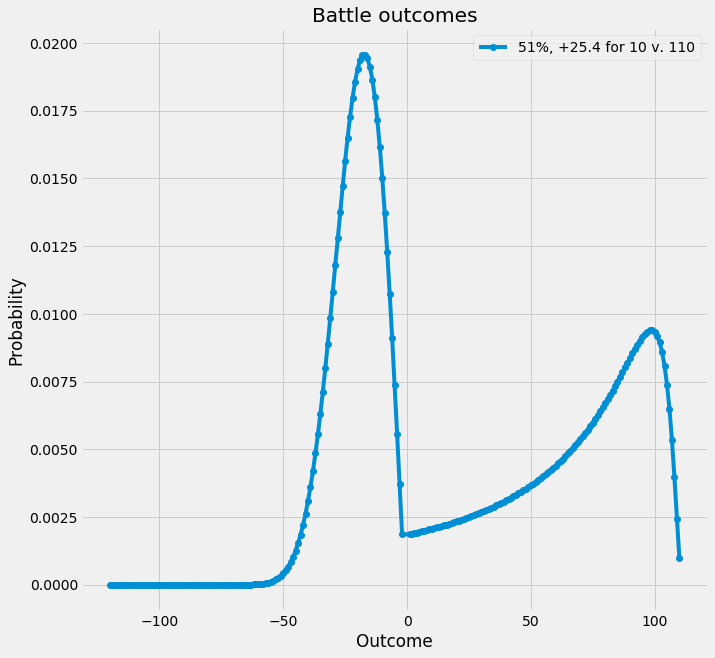

In [10]:
plot_remains([(10, 110)])

**Wow, I did not see that coming!** 

But on second thought, I probably should have. This is a bimodal distribution: one likely outcome is that the 10 dead soldiers are quickly killed off and the living have about 100 survivors. Another likely outcome is a long war of attrition where the dead finally triumph, with about 20 dead soldiers remaining. The least likely scenario is the dead winning 100 duels in a row, ending with 120 dead soldiers. Also unlikely is a near-even battle where we come down to one remaining on either side (that's the local minimum in the middle).


The label "`51%, +25.4 for 10 v. 110`" means that in this battle of 10 dead versus 110 living, the living have a 51% chance of winning, and the mean outcome is 25.4 living soldiers. (A negative number here would mean that only dead soldiers remain.)

Let's see more plots:

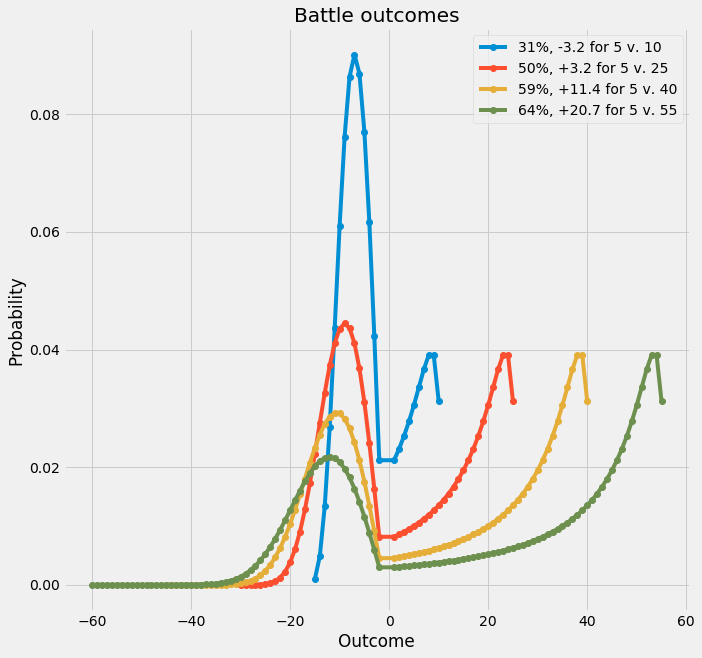

In [11]:
plot_remains([(5, a) for a in range(10, 60, 15)])

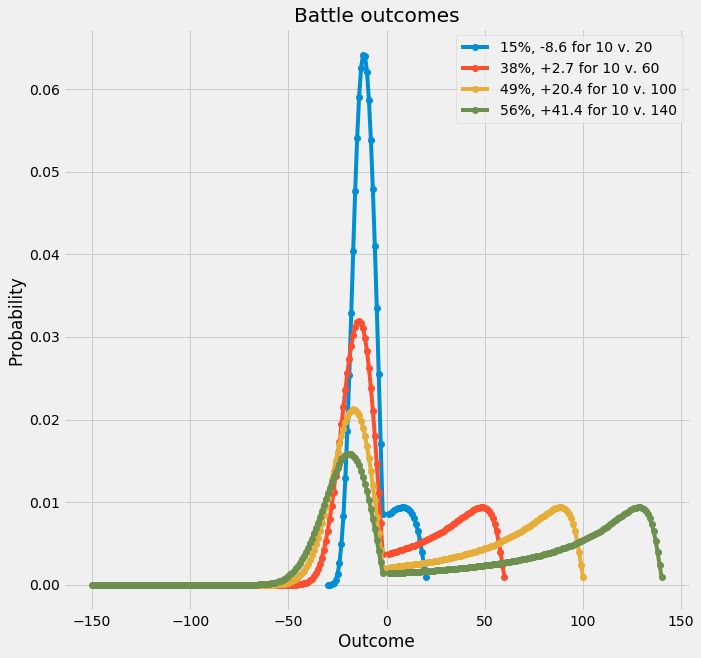

In [12]:
plot_remains([(10, a) for a in range(20, 150, 40)])

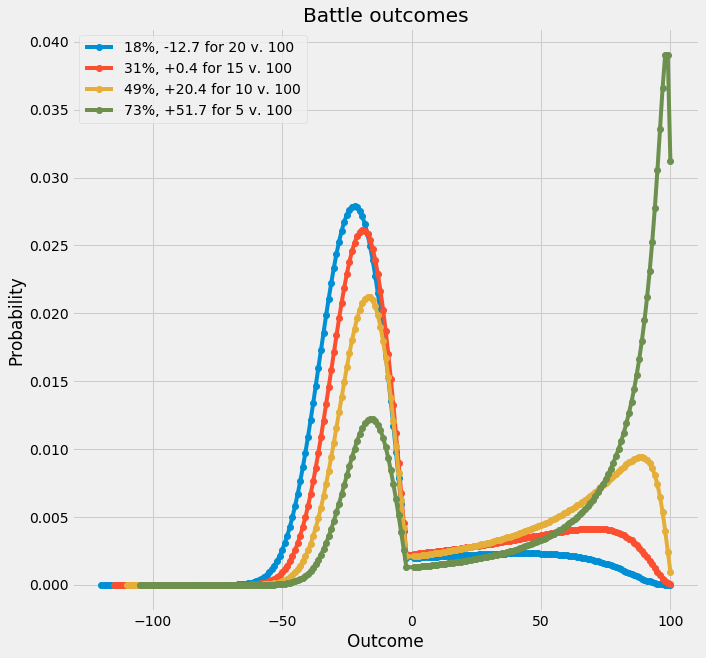

In [13]:
plot_remains([(d, 100) for d in reversed(range(5, 21, 5))])

# Other Thresholds Besides 50%

What if we want an 80% chance of winning, or some other percentage? 

I'll try to visualize that two ways, one with a color map, and one with contour lines:

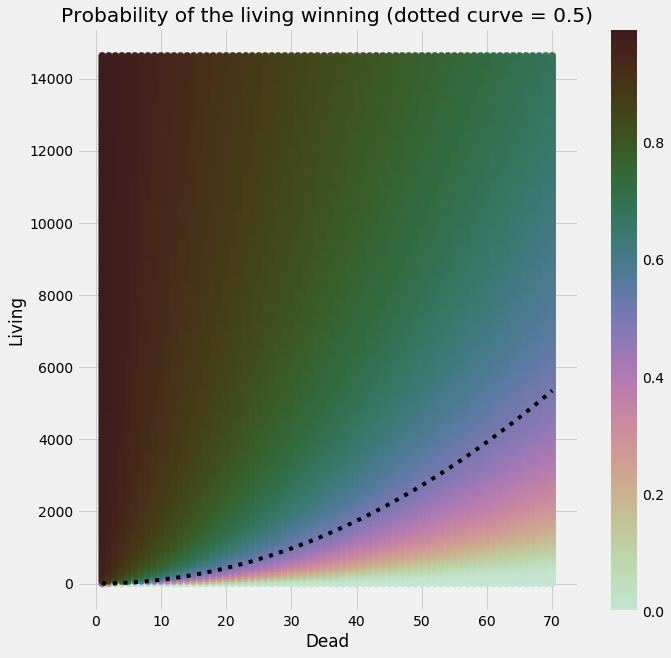

In [14]:
def colormap(D=range(1, 71)):
    "Display a dead vs alive rectangle, with color indicating P_live_win(dead, alive)."
    A = [living_needed(d) for d in D]
    n = max(D)
    points = [(d, a, P_live_win(d, a)) 
              for d in D 
              for a in range(1, 3 * n ** 2, n)]
    Ds, As, color = zip(*points)
    cmap = sns.cubehelix_palette(rot=2, as_cmap=True)
    fig, ax = plt.subplots()
    f = best_fit_quadratic(D, A)
    plt.plot(D, [f(d) for d in D], 'k:')
    plt.xlabel('Dead'); plt.ylabel('Living')
    plt.title('Probability of the living winning (dotted curve = 0.5)')
    fig.colorbar(ax.scatter(Ds, As, c=color, s=50, cmap=cmap))
    
colormap()

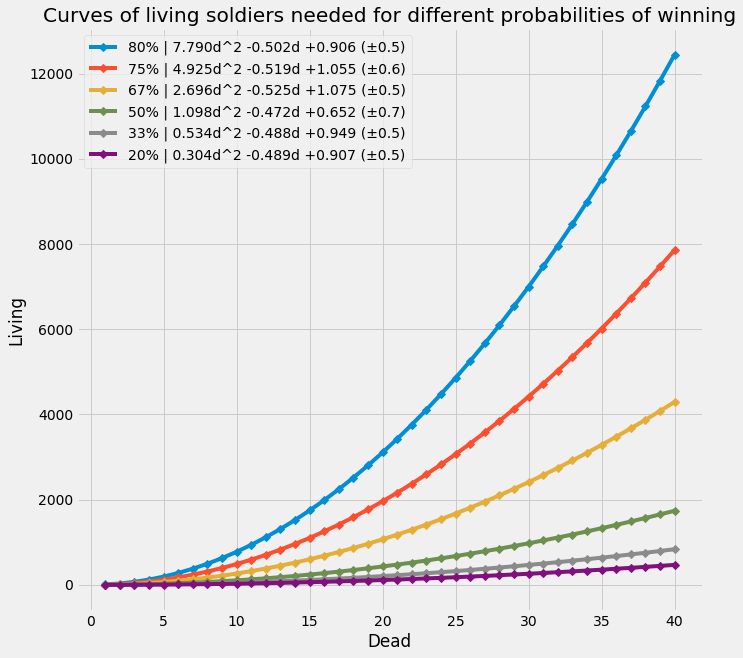

In [15]:
def contours(D=range(1, 41), probs=[4/5, 3/4, 2/3, 1/2, 1/3, 1/5]):
    "Living soldiers needed for different win percentages."
    for p in probs:
        A = [living_needed(d, p) for d in D]
        plt.plot(D, A, 'D-', label=f'{p:.0%} | {best_fit_quadratic(D, A).__doc__}')
    plt.legend(); plt.xlabel('Dead'); plt.ylabel('Living')
    plt.title('Curves of living soldiers needed for different probabilities of winning')

contours()